The goal of this Jupyter notebook is to introduce Machine Learning techniques through a concrete case study of credit scoring.

To do this, we will use the [UCI default of credit card clients Dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) to build a machine learning model that predict credit card default. The dataset contains 30.000 records (6.636 defaults) of credit card users in Taiwain. Each record contains 23 attributes describing the credit card user and his/her payment history.


# 1. Import the libraries that we will use in this tutorial

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('ggplot')

# 2. Read Data

In [4]:
data = pd.read_excel("default of credit card clients.xls", sheet_name=0, skiprows=1, index_col="ID")

In [5]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2**: Repayment status in August, 2005 (scale same as above)
* **PAY_3**: Repayment status in July, 2005 (scale same as above)
* **PAY_4**: Repayment status in June, 2005 (scale same as above)
* **PAY_5**: Repayment status in May, 2005 (scale same as above)
* **PAY_6**: Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)
* **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)
* **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)
* **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)
* **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)
* **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)
* **default payment next month**: Default payment (1=yes, 0=no)

# 3. Data Discovery

### How many defaults in the data set?

In [6]:
data["default payment next month"].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

### Default Ratio

In [7]:
data["default payment next month"].sum() / len(data["default payment next month"])

0.2212

6,636 out of 30,000 (or 22%) of clients will default next month. 

### Let's check if there are any anomalies in the data

In [8]:
data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Based on the numbers above, we can see that all the columns have no missing data 

In [9]:
# Bill Statement description
data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


Negative values can be interpreted as credit? Has to be investigated

# Visualization

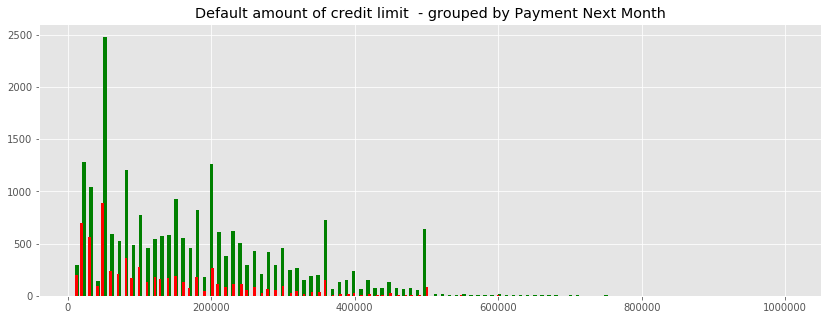

In [10]:
class_0 = data.loc[data["default payment next month"] == 0]["LIMIT_BAL"]
class_1 = data.loc[data["default payment next month"] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,5))
plt.title('Default amount of credit limit  - grouped by Payment Next Month')
plt.hist(class_0, bins=200, color="green")
plt.hist(class_1, bins=200, color="red")
plt.show()

# Training / Validation Split

80% for training and 20% for validation

In [11]:
train_df, val_df = train_test_split(data, test_size=0.20, random_state=2018, shuffle=True )

In [12]:
#Ratio of default in training data
print( train_df["default payment next month"].sum() / len(train_df["default payment next month"]) )

#Ratio of default in validation data
print( val_df["default payment next month"].sum() / len(val_df["default payment next month"]) )

0.22266666666666668
0.21533333333333332


# Let's build our first model - Decision Trees

In [13]:
target = "default payment next month"

predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [14]:
clf_dt = DecisionTreeClassifier()

### PUSH THE BUTTON FOR TRAINING

In [15]:
clf_dt.fit(train_df[predictors], train_df[target].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Predicition on training data to check if the model could model the data

In [16]:
preds_training = clf_dt.predict(train_df[predictors])
preds_proba_training = clf_dt.predict_proba(train_df[predictors])

In [17]:
roc_auc_score(train_df[target], preds_proba_training[:,1])

0.9999986910425505

#### Predicition on validation data

In [18]:
preds = clf_dt.predict(val_df[predictors])
preds_proba = clf_dt.predict_proba(val_df[predictors])

In [19]:
roc_auc_score(val_df[target], preds_proba[:,1])

0.6165464028029491

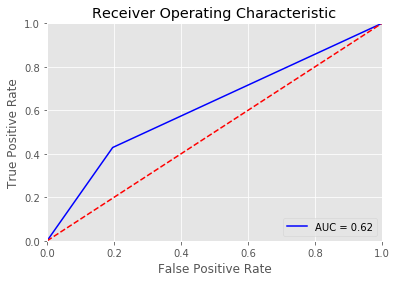

In [20]:
fpr, tpr, threshold = roc_curve(val_df[target], preds_proba[:,1])
roc_auc = roc_auc_score(val_df[target], preds_proba[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Let's build a stronger model - Random Forest

In [21]:
target = "default payment next month"

predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [22]:
clf_rf1 = RandomForestClassifier(criterion="gini",
                             n_estimators=500,
                             random_state=2018,
                             verbose=False)

### PUSH THE BUTTON FOR TRAINING

In [23]:
clf_rf1.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

#### Predicition on training data to check if the model could model the data

In [24]:
preds_training = clf_rf1.predict(train_df[predictors])
preds_proba_training = clf_rf1.predict_proba(train_df[predictors])

In [25]:
roc_auc_score(train_df[target], preds_proba_training[:,1])

0.9999933649398245

#### Predicition on validation data

In [26]:
preds = clf_rf1.predict(val_df[predictors])
preds_proba = clf_rf1.predict_proba(val_df[predictors])

In [27]:
roc_auc_score(val_df[target], preds_proba[:,1])

0.7648123311615036

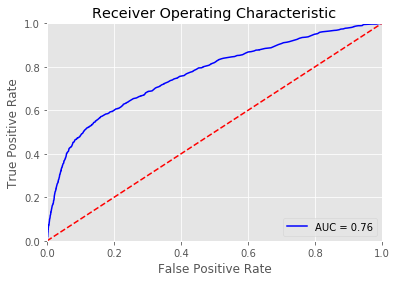

In [28]:
fpr, tpr, threshold = roc_curve(val_df[target], preds_proba[:,1])
roc_auc = roc_auc_score(val_df[target], preds_proba[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Let's improve on the model - Features Engineering

In [29]:
data['Closeness_6'] = (data["LIMIT_BAL"] - data["BILL_AMT6"]) / data["LIMIT_BAL"]
data['Closeness_5'] = (data["LIMIT_BAL"] - data["BILL_AMT5"]) / data["LIMIT_BAL"]
data['Closeness_4'] = (data["LIMIT_BAL"] - data["BILL_AMT4"]) / data["LIMIT_BAL"]
data['Closeness_3'] = (data["LIMIT_BAL"] - data["BILL_AMT3"]) / data["LIMIT_BAL"]
data['Closeness_2'] = (data["LIMIT_BAL"] - data["BILL_AMT2"]) / data["LIMIT_BAL"]
data['Closeness_1'] = (data["LIMIT_BAL"] - data["BILL_AMT1"]) / data["LIMIT_BAL"]

In [30]:
train_df, val_df = train_test_split(data, test_size=0.20, random_state=2018, shuffle=True )

In [31]:
target = "default payment next month"

predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
             "Closeness_1", "Closeness_2", "Closeness_3", "Closeness_4", "Closeness_5", "Closeness_6"]

In [32]:
 clf_rf2 = RandomForestClassifier(criterion="gini",
                             n_estimators=500,
                             random_state=2018,
                             verbose=False)

In [33]:
clf_rf2.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

#### Predicition on training data to check if the model could model the data

In [34]:
preds_training = clf_rf2.predict(train_df[predictors])
preds_proba_training = clf_rf2.predict_proba(train_df[predictors])

In [35]:
roc_auc_score(train_df[target], preds_proba_training[:,1])

0.9999936357586071

#### Predicition on validation data

In [36]:
preds = clf_rf2.predict(val_df[predictors])
preds_proba = clf_rf2.predict_proba(val_df[predictors])

In [37]:
roc_auc_score(val_df[target], preds_proba[:,1])

0.7650724114937753

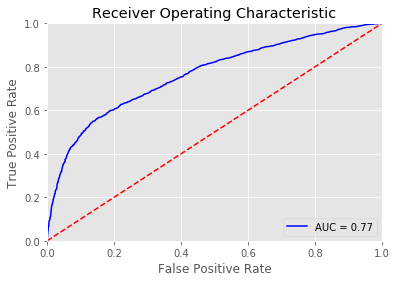

In [38]:
fpr, tpr, threshold = roc_curve(val_df[target], preds_proba[:,1])
roc_auc = roc_auc_score(val_df[target], preds_proba[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Features Importance

In [39]:
clf_rf2.feature_importances_

array([0.04098896, 0.00933686, 0.01561463, 0.01093114, 0.05350821,
       0.09138458, 0.04196551, 0.02591117, 0.02021608, 0.01688859,
       0.01604621, 0.04164291, 0.03706007, 0.03522464, 0.03359615,
       0.03375067, 0.03394736, 0.03856037, 0.03558361, 0.03424287,
       0.03132146, 0.03174399, 0.03444655, 0.04461688, 0.04095398,
       0.03877906, 0.03786034, 0.03632372, 0.03755341])

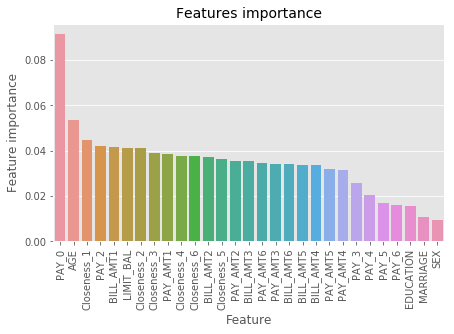

In [40]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_rf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

# Let's try another model - Gradient Boosting

In [41]:
target = "default payment next month"

predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
              'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
             "Closeness_1", "Closeness_2", "Closeness_3", "Closeness_4", "Closeness_5", "Closeness_6"]

In [42]:
clf_gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=4, random_state=2018)

In [43]:
clf_gb.fit(train_df[predictors], train_df[target].values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=2018, subsample=1.0, verbose=0,
              warm_start=False)

#### Predicition on training data to check if the model could model the data

In [44]:
preds_training = clf_gb.predict(train_df[predictors])
preds_proba_training = clf_gb.predict_proba(train_df[predictors])

In [45]:
roc_auc_score(train_df[target], preds_proba_training[:,1])

0.8091084812177746

#### Predicition on validation data

In [46]:
preds = clf_gb.predict(val_df[predictors])
preds_proba = clf_gb.predict_proba(val_df[predictors])

In [47]:
roc_auc_score(val_df[target], preds_proba[:,1])

0.7868018602155346

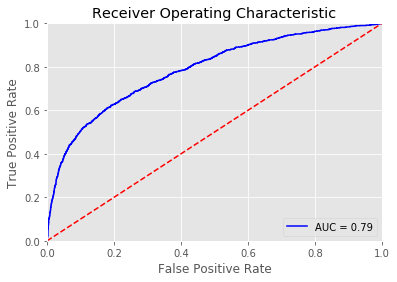

In [48]:
fpr, tpr, threshold = roc_curve(val_df[target], preds_proba[:,1])
roc_auc = roc_auc_score(val_df[target], preds_proba[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

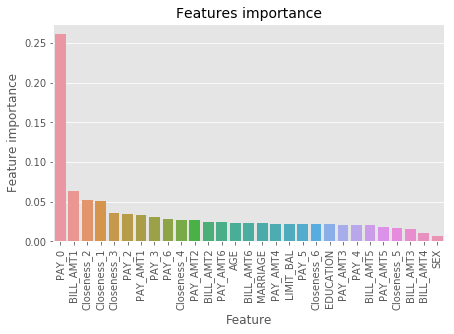

In [49]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_gb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

### References

[1] https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook

[2] https://www.kaggle.com/gpreda/default-of-credit-card-clients-predictive-models